In [184]:
import gzip
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from collections import defaultdict

In [212]:
product_ids = []
product_title = []
product_group = []
product_salesrank = []
product_reviews = []
product_downloaded = []
product_rating = []

review_product = []
review_date = []
review_customer = []
review_rating = []
review_vote = []
review_helpful = []

categories = defaultdict(set)
cat_flag = False

with gzip.open('amazon-meta.txt.gz', 'rt') as infile:
    for line in infile:
        if line.startswith('ASIN:'):
            temp, product = line.split()
        if line.strip().startswith('title:'):
            temp, title = line.split(':', maxsplit=1)
            title = title.strip()
            product_ids.append(product)
            product_title.append(title)
        if line.strip().startswith('group:'):
            temp, group = line.split(':')
            group = group.strip()
            product_group.append(group)
        if line.strip().startswith('salesrank:'):
            temp, salesrank = line.split()
            product_salesrank.append(int(salesrank))
        if line.strip().startswith('categories:'):
            info = line.split()
            ncat = int(info[1])
            cat_flag = True
        elif cat_flag and not line.strip().startswith('reviews:'):
            categories[group] |= set([s.strip() for s in line.split('|')])
#             categories[group].add(line.strip())
        if line.strip().startswith('reviews:'):
            cat_flag = False
            review_info = line.split()
            product_reviews.append(int(review_info[2]))
            product_downloaded.append(int(review_info[4]))
            product_rating.append(float(review_info[-1]))
        if 'cutomer' in line:
            review_info = line.split()
            review_product.append(product)
            review_date.append(review_info[0])
            review_customer.append(review_info[2])
            review_rating.append(int(review_info[4]))
            review_vote.append(int(review_info[6]))
            review_helpful.append(int(review_info[8]))

products = pd.DataFrame({'product_id': product_ids, 'title': product_title, 'group': product_group,
                         'salesrank': product_salesrank, 'reviews': product_reviews,
                         'downloaded_reviews': product_downloaded, 'rating': product_rating})
reviews = pd.DataFrame({'product_id': review_product, 'date': review_date, 'customer_id': review_customer, 
                       'rating': review_rating, 'votes': review_vote, 'helpful': review_helpful})

In [97]:
products.head()

,downloaded_reviews,group,product_id,rating,reviews,salesrank,title
0,2,Book,0827229534,5.0,2,396585,Patterns of Preaching: A Sermon Sampler
1,12,Book,0738700797,4.5,12,168596,Candlemas: Feast of Flames
2,1,Book,0486287785,5.0,1,1270652,World War II Allied Fighter Planes Trading Cards
3,1,Book,0842328327,4.0,1,631289,Life Application Bible Commentary: 1 and 2 Tim...
4,0,Book,1577943082,0.0,0,455160,Prayers That Avail Much for Business: Executive


In [98]:
reviews.head()

,customer_id,date,helpful,product_id,rating,votes
0,A2JW67OY8U6HHK,2000-7-28,9,0827229534,5,10
1,A2VE83MZF98ITY,2003-12-14,5,0827229534,5,6
2,A11NCO6YTE4BTJ,2001-12-16,4,0738700797,5,5
3,A9CQ3PLRNIR83,2002-1-7,5,0738700797,4,5
4,A13SG9ACZ9O5IM,2002-1-24,8,0738700797,5,8


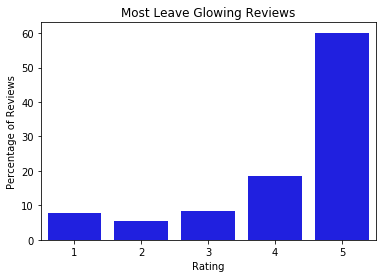

In [148]:
counts = reviews.groupby('rating').votes.count()
sns.barplot(grouped.index, 100.0 * counts / len(reviews), color='blue')
plt.xlabel('Rating')
plt.ylabel('Percentage of Reviews')
plt.title('Most Leave Glowing Reviews')
plt.show()

In [144]:
print('The average review in the dataset is {:.2f}'.format(review.rating.mean()))

The average review in the dataset is 4.18


In [145]:
print('5-star reviews make up {:.2f}% of all reviews'.format(100.0 * sum(review.rating==5) / len(review)))

5-star reviews make up 60.11% of all reviews


In [146]:
print('4 and 5-star reviews make up {:.2f}% of all reviews'.format(100.0 * sum(review.rating>3) / len(review)))

4 and 5-star reviews make up 78.57% of all reviews


In [213]:
len(categories['Book'])

14924

In [214]:
categories['Book']

{'',
 'Ships[300362]',
 'Poetry[1038386]',
 'Oklahoma[17378]',
 'Soos, Troy[69650]',
 'Electrical[3045791]',
 'Bull, Emma[14853]',
 'Seminary[172801]',
 'Hardcover[285764]',
 'Anthologies[10137]',
 'Civil Service[11663]',
 'Spencer, Stanley[68004]',
 '19th Century[9932]',
 'Large Print[287390]',
 'State & Local[4872]',
 'Ecology[491708]',
 'Large Print[287430]',
 'Dunnett, Dorothy[69410]',
 'Colonial & Revolutionary[2955]',
 'Joyce, James[287243]',
 'Atherton, Nancy[69331]',
 'Rural Health[227570]',
 'Kelman, Judith[69502]',
 'General[465180]',
 'Burke, James Lee[585776]',
 'General[727798]',
 'Meteorology[13612]',
 'Verne, Jules[170861]',
 'Travel Games[4451]',
 'Ada[3953]',
 'Classics[10023]',
 'Steeple Hill Love Inspired[13432]',
 'Intermediate[727692]',
 'Research & Theory[227664]',
 'Shapiro, David[70607]',
 'Software Project Management[727878]',
 "Beginner's Nook[281043]",
 'Van Gogh, Vincent[1444]',
 'Italy[640462]',
 'Hardcover[286495]',
 'Cimabue[1171]',
 'Hartwell, David G.[1

In [215]:
products.group.unique()

array(['Book', 'Music', 'DVD', 'Video', 'Toy', 'Video Games', 'Software',
       'Baby Product', 'CE', 'Sports'], dtype=object)

In [216]:
sum([len(x) for x in categories.values()])

51661